In [1]:
#!/usr/bin/env python
"""
Robust B-Spline regression with scikit-learn
"""

import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as si
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, RANSACRegressor,\
                                 TheilSenRegressor, HuberRegressor

from sklearn.metrics import mean_squared_error

In [10]:
import numpy as np
import scipy.interpolate as si
from sklearn.base import TransformerMixin


def get_bspline_basis(t, positions, degree: int = 3, periodic: bool = False):
    """Get basis matrix for b-splines.
    
    See also https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html#scipy.interpolate.splrep
    
    Usage: B = get_bspline_basis(t=np.arange(0, 100), positions=np.arange(5, 100, 10))
    
    Args:
        t (array-like): Time points at which the splines are evaluated.
        positions (list-like): Positions of individual basis functions.
        degree (int): Polynomial degree of the splines. Defaults to 3.
        periodic (bool): . Defaults to False.

    Returns:
        [nb_positions, t] matrix with basis functions
    
    """
    npositions = len(positions)
    y_dummy = np.zeros(npositions)

    positions, coeffs, degree = si.splrep(positions, y_dummy, k=degree,
                                      per=periodic)
    ncoeffs = len(coeffs)
    bsplines = []
    for ispline in range(npositions):
        coeffs = [1.0 if ispl == ispline else 0.0 for ispl in range(ncoeffs)]
        bsplines.append((positions, coeffs, degree))
    
    B = np.array([si.splev(t, spline) for spline in bsplines])
    return B


class BasisProjection(TransformerMixin):
    def __init__(self, basis):
        """Init BasisProjection transformer with a basis matrix
        
        Args:
            basis (array-like): [nb_bases, time] matrix of bases
        """
        self.basis = basis
        self.nb_bases, self.nb_times = self.basis.shape[:2]
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Project data from time domain onto bases.
        Args:
            X [nb_samples, time] or [time,]

        Returns:
            X_transformed [nb_samples, nb_bases]
            
        """
        if X.shape[1] != self.nb_times:
            raise ValueError(f"Wrong shape for X. Needs to be [{self.nb_times},:], is {X.shape}.")
        X_transformed = np.dot(X, self.basis.T)  #??
        return X_transformed

    def inverse_transform(self, X_transformed):
        """Reconstruct time-domain representation from basis-projected data.
        
        Args:
            X_transformed [nb_samples, nb_bases] or [nb_bases,]
        Returns:
            X_reconstructed [nb_samples, time]        
        """
        if X_transformed.shape[1] != self.nb_bases:
            raise ValueError(f"Wrong shape for X_transformed. Needs to be [{self.nb_bases},:], is {X_transformed.shape}.")
        
        X_reconstructed = np.dot(X_transformed, self.basis)  #??
        return X_reconstructed


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
B (10, 100) bases 10 times 100
X (1000, 100)
Xt (1000, 10)
Xr (1000, 100)


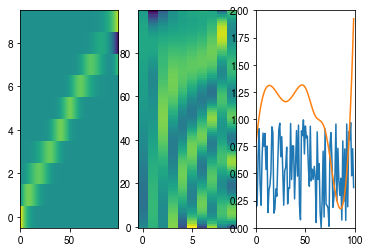

In [11]:
# test
B = get_bspline_basis(np.arange(0, 100), np.arange(0, 100, 10))
B = B / np.linalg.norm(B, axis=1)[:,np.newaxis]  # norm rows

# orthogonalize rows
import scipy
B_orth = scipy.linalg.orth(B.T)

print(np.linalg.norm(B, axis=1))
bp = BasisProjection(B)
X = np.random.random((1000, 100))
print('B', B.shape, 'bases', bp.nb_bases, 'times', bp.nb_times)
print('X', X.shape)
Xt = bp.transform(X)
print('Xt', Xt.shape)

Xr = bp.inverse_transform(Xt)
print('Xr', Xr.shape)
plt.subplot(131)
plt.imshow(B)

plt.subplot(132)
plt.imshow(B_orth)

plt.subplot(133)
plt.plot(X[100,:])
plt.plot(Xr[100,:])


In [8]:
np.random.seed(42)
X = np.random.uniform(low=-30, high=30, size=400)
x_predict = np.linspace(-25, 25, 1000)
y = np.sin(2 * np.pi * 0.1 * X)
X_test = np.random.uniform(low=-30, high=30, size=200)
y_test = np.sin(2 * np.pi * 0.1 * X_test)

y_errors_large = y.copy()
y_errors_large[::10] = 6

# Make sure that X is 2D
X = X[:, np.newaxis]
X_test = X_test[:, np.newaxis]

# predict y
knots = np.linspace(-30, 30, 20)
bspline_features = BSplineFeatures(knots, degree=3, periodic=False)
estimators = [('Least-Square', '-', 'C0',
               LinearRegression(fit_intercept=False)),
              ('Theil-Sen', '>', 'C1', TheilSenRegressor(random_state=42)),
              ('RANSAC', '<', 'C2', RANSACRegressor(random_state=42)),
              ('HuberRegressor', '--', 'C3', HuberRegressor())]

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
fig.suptitle('Robust B-Spline Regression with SKLearn')
ax.plot(X[:, 0], y_errors_large, 'o', ms=5, c='black',
        label='data points [10% outliers]')

for label, style, color, estimator in estimators:
    model = make_pipeline(bspline_features, estimator)
    model.fit(X, y_errors_large)
    mse = mean_squared_error(model.predict(X_test), y_test)
    y_predicted = model.predict(x_predict[:, None])
    ax.plot(x_predict, y_predicted, style, lw=2, markevery=8, ms=6,
            color=color, label=label + ' E={:2.2g}'.format(mse))
ax.legend(loc='upper right', framealpha=0.95)
ax.set(ylim=(-2, 8), xlabel='time [s]', ylabel='amplitude')
plt.show()


NameError: name 'BSplineFeatures' is not defined

In [9]:
knots = np.linspace(-300, 300, 10)
t = np.linspace(0, 300)


bspline_features = BSplineFeatures(knots, degree=3, periodic=False)
Xt = bspline_features.transform(X)
print(X.shape, Xt.shape)

NameError: name 'BSplineFeatures' is not defined

In [5]:
nsamples, nfeatures = X.shape
features = np.zeros((nsamples, nfeatures * bspline_features.nsplines))
B = [si.splev(t, spline) for spline in bspline_features.bsplines]
# plt.plot(t, np.array(B).T)

plt.imshow(np.array(B))



NameError: name 'bspline_features' is not defined

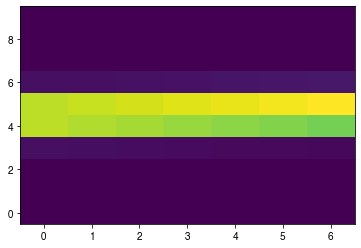

In [19]:

B = [si.splev(t, spline) for spline in bspline_features.bsplines]

plt.imshow(B)


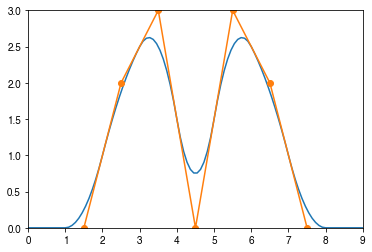

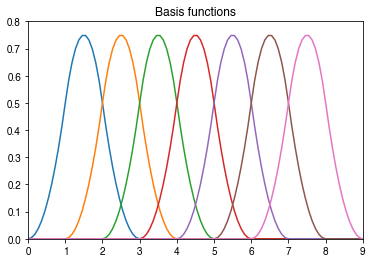

In [9]:
import numpy

import matplotlib.pyplot as plt

# This is the basis function described in eq 3.6 in http://research.microsoft.com/en-us/um/people/ablake/contours/
def func(x, offset):
    out = numpy.ndarray((len(x)))

    for i, v in enumerate(x):
        s = v - offset

        if s >= 0 and s < 1:
            out[i] = s * s / 2.0
        elif s >= 1 and s < 2:
            out[i] = 3.0 / 4.0 - (s - 3.0 / 2.0) * (s - 3.0 / 2.0)
        elif s >= 2 and s < 3:
            out[i] = (s - 3.0) * (s - 3.0) / 2.0
        else:
            out[i] = 0.0

    return out

# We have 7 things to fit, so let's do 7 basis functions?
y = numpy.array([0, 2, 3, 0, 3, 2, 0])

# We need enough x points for all the basis functions... That's why the weird linspace max here
x = numpy.linspace(0, len(y) + 2, 100)

B = numpy.ndarray((len(x), len(y)))

for k in range(len(y)):
    B[:, k] = func(x, k)

plt.plot(x, B.dot(y))
# The x values in the next statement are the maximums of each basis function. I'm not sure at all this is right
plt.plot(numpy.array(range(len(y))) + 1.5, y, '-o')
# plt.legend('B-spline', 'Control points')
plt.show()

for k in range(len(y)):
    plt.plot(x, B[:, k])
plt.title('Basis functions')
plt.show()

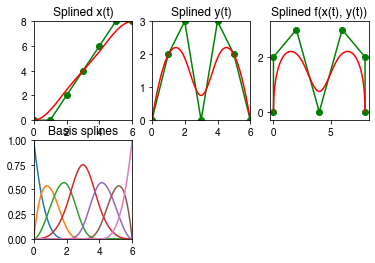

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si

points = [[0, 0], [0, 2], [2, 3], [4, 0], [6, 3], [8, 2], [8, 0]];
points = np.array(points)
x = points[:,0]
y = points[:,1]

t = range(len(points))
ipl_t = np.linspace(0.0, len(points) - 1, 100)

x_tup = si.splrep(t, x, k=3)
y_tup = si.splrep(t, y, k=3)

x_list = list(x_tup)
xl = x.tolist()
x_list[1] = xl + [0.0, 0.0, 0.0, 0.0]

y_list = list(y_tup)
yl = y.tolist()
y_list[1] = yl + [0.0, 0.0, 0.0, 0.0]

x_i = si.splev(ipl_t, x_list)
y_i = si.splev(ipl_t, y_list)

#==============================================================================
# Plot
#==============================================================================

fig = plt.figure()

ax = fig.add_subplot(231)
plt.plot(t, x, '-og')
plt.plot(ipl_t, x_i, 'r')
plt.xlim([0.0, max(t)])
plt.title('Splined x(t)')

ax = fig.add_subplot(232)
plt.plot(t, y, '-og')
plt.plot(ipl_t, y_i, 'r')
plt.xlim([0.0, max(t)])
plt.title('Splined y(t)')

ax = fig.add_subplot(233)
plt.plot(x, y, '-og')
plt.plot(x_i, y_i, 'r')
plt.xlim([min(x) - 0.3, max(x) + 0.3])
plt.ylim([min(y) - 0.3, max(y) + 0.3])
plt.title('Splined f(x(t), y(t))')

ax = fig.add_subplot(234)
for i in range(7):
    vec = np.zeros(11)
    vec[i] = 1.0
    x_list = list(x_tup)
    x_list[1] = vec.tolist()
    x_i = si.splev(ipl_t, x_list)
    plt.plot(ipl_t, x_i)
plt.xlim([0.0, max(t)])
plt.title('Basis splines')
plt.show()

In [102]:
B = np.zeros((10, 100))
X = np.zeros((1000,100,))
Xt = np.dot(X, B.T)
print(Xt.shape)
Xr = np.dot(Xt, B)
print(Xr.shape)

(1000, 10)
(1000, 100)


In [103]:
Xt = np.zeros((10,))
Xr = np.dot(Xt, B)
print(Xr.shape)

(100,)


2